# Предсказание пола клиента по его транзакциям

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('max_columns', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth', 300)

## Загрузка данных

In [2]:
tr_mcc_codes = pd.read_csv('/kaggle/input/transactions-predict-gender/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('/kaggle/input/transactions-predict-gender/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('/kaggle/input/transactions-predict-gender/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('/kaggle/input/transactions-predict-gender/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('/kaggle/input/transactions-predict-gender/gender_test_kaggle_sample_submission.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

## Анализ данных

#### transactions.csv

Этот файл содержит информацию о всех транзакциях пользователей без указания принадлежности к классу.

In [3]:
print(transactions.info())
print('\n')
print(transactions.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849346 entries, 39026145 to 61870738
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   tr_datetime  object 
 1   mcc_code     int64  
 2   tr_type      int64  
 3   amount       float64
 4   term_id      object 
dtypes: float64(1), int64(2), object(2)
memory usage: 345.8+ MB
None


tr_datetime          0
mcc_code             0
tr_type              0
amount               0
term_id        2765195
dtype: int64


В столбце <code>term_id</code> присутствует большое количество пропущенных значений. Использовать его в обучении модели бессмысленно.

#### tr_mcc_codes.csv

В файле присутствуют описания всех MCC кодов.

In [4]:
tr_mcc_codes.head()

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу"
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигде более не классифицированные"
2741,Разнообразные издательства/печатное дело


#### tr_types.csv

Файл содержит описание всех типов транзакций.

In [5]:
tr_types.head()

,tr_description
tr_type,
3200,Плата за предоставление услуг посредством мобильной связи
3210,Плата за предоставление отчета по счету карты почтой
3800,Плата за обслуживание банковской карты (за первый год)
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в других ТБ)


<code>gender_train</code> - пользователи, принадлежащие к тренировочной выборке

<code>gender_test</code> - пользователи, принадлежащие к тестовой выборке

<AxesSubplot:>

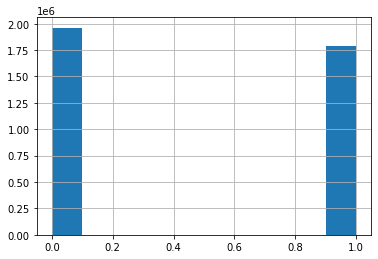

In [6]:
# Соотношение классов
transactions_train.gender.hist()

Этот датасет достаточно сбалансирован по классам.

Text(0, 0.5, 'Количество')

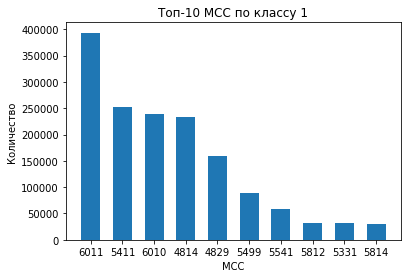

In [7]:
x_mcc_1 = transactions_train[transactions_train.gender == 1].mcc_code.value_counts().head(10).index.astype(str)
y_mcc_1 = transactions_train[transactions_train.gender == 1].mcc_code.value_counts().head(10).values

plt.bar(x_mcc_1, y_mcc_1, width=0.6)
plt.title('Топ-10 MCC по классу 1')
plt.xlabel('MCC')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

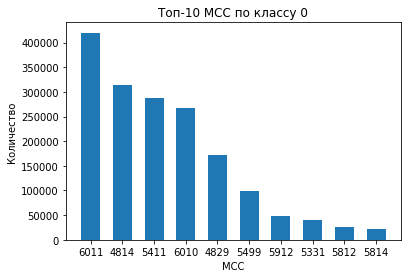

In [8]:
x_mcc_0 = transactions_train[transactions_train.gender == 0].mcc_code.value_counts().head(10).index.astype(str)
y_mcc_0 = transactions_train[transactions_train.gender == 0].mcc_code.value_counts().head(10).values

plt.bar(x_mcc_0, y_mcc_0, width=0.6)
plt.title('Топ-10 MCC по классу 0')
plt.xlabel('MCC')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

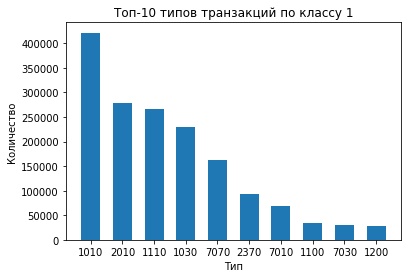

In [9]:
x_tr_1 = transactions_train[transactions_train.gender == 1].tr_type.value_counts().head(10).index.astype(str)
y_tr_1 = transactions_train[transactions_train.gender == 1].tr_type.value_counts().head(10).values

plt.bar(x_tr_1, y_tr_1, width=0.6)
plt.title('Топ-10 типов транзакций по классу 1')
plt.xlabel('Тип')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

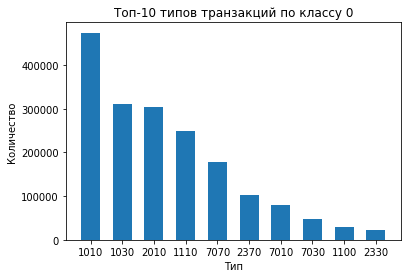

In [10]:
x_tr_0 = transactions_train[transactions_train.gender == 0].tr_type.value_counts().head(10).index.astype(str)
y_tr_0 = transactions_train[transactions_train.gender == 0].tr_type.value_counts().head(10).values

plt.bar(x_tr_0, y_tr_0, width=0.6)
plt.title('Топ-10 типов транзакций по классу 0')
plt.xlabel('Тип')
plt.ylabel('Количество')

## Генерация фичей

Для тренировки модели, создадим временные фичи:
- Номер дня в месяце
- Месяц
- День
- Час
- Тип дня (будни, пятница, выходные)
- Время суток (утро, день, вечер, ночь)

In [11]:
def conditions_day(x):
    if x == 4:
        return 'friday'
    elif (x == 5 or x == 6):
        return 'weekend'
    else:
        return 'weekday'
conds_d = np.vectorize(conditions_day)

def conditions_hour(x):
    if (x >= 6) and (x < 12):
        return 'morning'
    elif (x >= 12) and (x < 18):
        return 'daytime'
    elif (x >= 18) and (x <= 23):
        return 'evening'
    else:
        return 'night'
conds_h = np.vectorize(conditions_hour)

for df in [transactions_train, transactions_test]:
    df['day_month'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 30)
    df['month'] = df['tr_datetime'].str.split().apply(lambda x: (int(x[0]) // 30) % 12)
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    type_day = conds_d(df['day'])
    df['type_day'] = type_day
    part_day = conds_h(df['hour'])
    df['part_day'] = part_day

transactions_train.head()

,tr_datetime,mcc_code,tr_type,amount,term_id,gender,day_month,month,day,hour,type_day,part_day
customer_id,,,,,,,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,1,1,0,1,15,weekday,daytime
22899,2 20:52:48,4814,1030,-2245.92,NaN,1,2,0,2,20,weekday,evening
22899,5 18:52:19,6011,2010,-44918.32,NaN,1,5,0,5,18,weekend,evening
22899,6 12:28:22,6011,2010,-150476.36,NaN,1,6,0,6,12,weekend,daytime
22899,28 10:41:01,6010,7030,33688.74,NaN,1,28,0,0,10,weekday,morning


Посчитаем для каждого пользователя количество транзакций в определенные часы, дни, месяцы. Разделим транзакции на положительные (пришли средства) и отрицательные (ушли средства), а затем на основе этого посчитаем для каждого пользователя минимум, максимум, среднее, медиану и другие агрегирующие функции. Также, посчитаем количество транзакций по MCC кодам и типам транзакций.

In [12]:
tqdm_notebook.pandas(desc="Progress:")

def features_advanced(x): 
    features = []
    features.append(pd.Series(x['day_month'].value_counts(normalize=True).add_prefix('day_month_')))
    features.append(pd.Series(x['month'].value_counts(normalize=True).add_prefix('month_')))
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['type_day'].value_counts(normalize=True).add_prefix('type_day_')))
    features.append(pd.Series(x['part_day'].value_counts(normalize=True).add_prefix('part_day_')))
    
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))

    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_')))
    features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_')))
    features.append(pd.Series(x[['day_month', 'part_day']].value_counts(normalize=True).add_prefix('dm_pd_')))
    
    return pd.concat(features)

In [13]:
data_train = transactions_train.groupby(transactions_train.index)\
                            .progress_apply(features_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                            .progress_apply(features_advanced).unstack(-1)

target = data_train.join(gender_train, how='inner')['gender']
target.value_counts()

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

0    4687
1    3713
Name: gender, dtype: int64

In [14]:
X = data_train.copy()
y = target
test_df = data_test.copy()

# Заполним пустые значения нулями
X.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

X.shape, test_df.shape

((8400, 474), (3600, 472))

## Модель

In [15]:
# Подобранные оптимальные гиперпараметры

params = {
    'num_trees': 270,
    'learning_rate': 0.08,
    'depth': 6,
    'l2_leaf_reg': 2.5,
    'verbose' : False
}

Оценим модель по метрикам ROC AUC и F1.

In [16]:
train_indices, test_indices = train_test_split(y.index, test_size=0.2)

train_x = X.loc[train_indices, :]
train_y = y.loc[train_indices]

test_x = X.loc[test_indices, :]
test_y = y.loc[test_indices]

model = CatBoostClassifier(**params)
model.fit(train_x, train_y)

In [17]:
y_pred = model.predict(test_x)
metric_auc = roc_auc_score(test_y, y_pred)
metric_f1 = f1_score(test_y, y_pred)

print('ROC AUC:', metric_auc)
print('F1 score:', metric_f1)

ROC AUC: 0.7801023614977104
F1 score: 0.7527472527472528


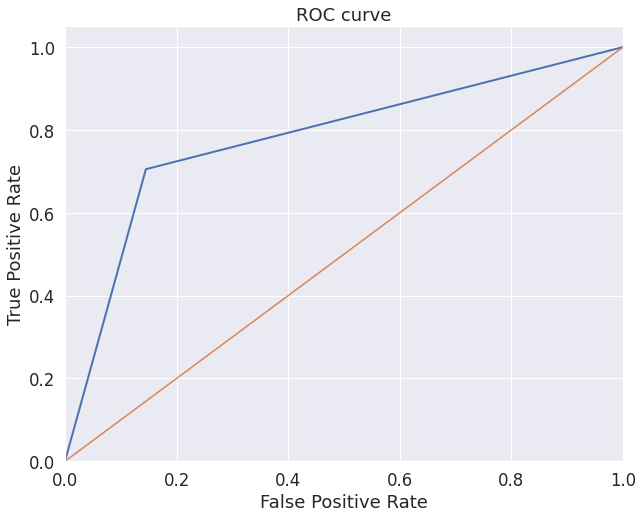

In [18]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Обучим модель на всех данных

In [19]:
pred_model = CatBoostClassifier(**params)

pred_model.fit(X, y)

In [20]:
predict = pred_model.predict_proba(test_df)

In [21]:
submission = pd.DataFrame(index=data_test.index)
submission['probability'] = predict[:,1]
submission.to_csv('final_submission.csv')
submission.head()

,probability
customer_id,
6815,0.460374
27914,0.811062
31385,0.072757
38084,0.019044
78659,0.659438
